## _*Using Qiskit Aqua for max-cut problems*_

This Qiskit Aqua Optimization notebook demonstrates how to use the VQE quantum algorithm to compute the max cut of a given graph. 

The problem is defined as follows. Given a graph $G = (V,E)$ with weights $w_{ij}$ on the edges, we are looking for a subset $S \subseteq V$ such that $\sum_{(i,j) \in E : i \in S, j \not\in S} w_{ij}$ is maximized.

The graph provided as an input is used first to generate an Ising Hamiltonian, which is then passed as an input to VQE.  As a reference, this notebook also computes the max cut using the Exact Eigensolver classical algorithm and the solver embedded in the commercial non-quantum IBM CPLEX product (if it is available in the system and the user has followed the necessary configuration steps in order for Qiskit Aqua to find it).  Please refer to the Qiskit Aqua Optimization documentation for installation and configuration details for CPLEX.

In [2]:
import numpy as np

from qiskit import BasicAer
from qiskit.optimization.ising import max_cut
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.optimization.ising.common import parse_gset_format, random_graph, sample_most_likely

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the max-cut problem. We load a small sample instance of the max-cut problem.

In [3]:
# w = parse_gset_format('sample.maxcut')
# qubitOp, offset = max_cut.get_operator(w)

We also offer a function to generate a random graph as a input.

In [4]:
if True:
    np.random.seed(8123179)
    w = random_graph(4, edge_prob=0.5, weight_range=10)
    qubitOp, offset = max_cut.get_operator(w)
print(w)

[[ 0.  8. -9.  0.]
 [ 8.  0.  7.  9.]
 [-9.  7.  0. -8.]
 [ 0.  9. -8.  0.]]


[[0. 2. 1. 4. 0. 0.]
 [2. 0. 1. 0. 0. 0.]
 [1. 1. 0. 2. 0. 0.]
 [4. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


{'paulis': [{'label': 'IIIIZZ', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'IIIZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IIIZZI', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IIZIIZ', 'coeff': {'real': 2.0, 'imag': 0.0}},
  {'label': 'IIZZII', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'ZZIIII', 'coeff': {'real': 0.5, 'imag': 0.0}}]}

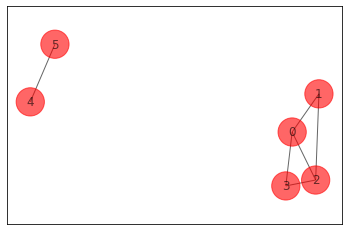

In [28]:
# generate a graph
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes

%matplotlib inline
n = 6
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
# E = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),(4,5,1.0)]
E = [(0,1,2.0),(0,2,1.0),(0,3,4.0),(1,2,1.0),(2,3,2.0),(4,5,1.0)]
# E = [(0,1,1.0)]
G.add_weighted_edges_from(E)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

# build a weight matrix from G
w = np.zeros([n,n])
for i, j, data in G.edges.data():
    w[i][j] = data['weight']
    w[j][i] = data['weight']
print(w)
qubitOp, offset = max_cut.get_operator(w)
qubitOp.to_dict()

Here we test for the presence of algorithms we want to use in this notebook. If Aqua is installed correctly `ExactEigensolver` and `VQE` will always be found. `CPLEX.Ising` is dependent on IBM CPLEX being installed (see introduction above). CPLEX is *not required* but if installed then this notebook will demonstrate the `CPLEX.Ising` algorithm , that uses CPLEX, to compute max-cut as well.

In [29]:
to_be_tested_algos = ['ExactEigensolver', 'CPLEX.Ising', 'VQE']
print(to_be_tested_algos)

['ExactEigensolver', 'CPLEX.Ising', 'VQE']


We can now use the Operator without regard to how it was created. First we need to prepare the configuration params to invoke the algorithm. Here we will use the ExactEigensolver first to return the smallest eigenvalue. Backend is not required since this is computed classically not using quantum computation. We then add in the qubitOp Operator in dictionary format. The result is a dictionary.

In [30]:
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -4.5
max-cut objective: -10.0
solution: [1. 0. 1. 0. 0. 1.]
solution objective: 10.0


*Note*: IBM CPLEX is an _optional_ installation addition for Aqua. If installed then the Aqua CPLEX.Ising algorithm will be able to be used. If not, then solving this problem using this particular algorithm will simply be skipped. 

We change the configuration parameters to solve it with the CPLEX backend. The CPLEX backend can deal with a particular type of Hamiltonian called Ising Hamiltonian, which consists of only Pauli Z at most second order and often for combinatorial optimization problems that can be formulated as quadratic unconstrained binary optimization problems, such as the max-cut problem.

Note that for a max-cut problem, since we are computing a bipartition of the graph, every binary vector $x$ and its complement (i.e., the vector $y$ such that $y_j = 1 - x_j$ for all $j$) represent exactly the same solution, and will have the same objective function value. Different solution methods may return solutions that look different, but in fact have the same objective function value.

In [31]:
try:
    from qiskit.aqua.algorithms import CPLEX_Ising
    result = CPLEX_Ising(qubitOp, display=0).run()

    x_dict = result['x_sol']
    print('energy:', result['energy'])
    print('time:', result['eval_time'])
    print('max-cut objective:', result['energy'] + offset)
    x = np.array([x_dict[i] for i in sorted(x_dict.keys())])
    print('solution:', max_cut.get_graph_solution(x))
    print('solution objective:', max_cut.max_cut_value(x, w))
except Exception as ex:
    print(str(ex))

cannot import name 'CPLEX_Ising' from 'qiskit.aqua.algorithms' (/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/__init__.py)


Now we want VQE and so change it and add its other configuration parameters.

In [32]:
vqe = VQE(qubitOp,
          RYRZ(qubitOp.num_qubits, depth=3, entanglement='linear'),
          L_BFGS_B(maxfun=6000))
%time result = vqe.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -4.499999999967843
time: 24.880064010620117
max-cut objective: -9.999999999967843
solution: [1. 0. 1. 0. 0. 1.]
solution objective: 10.0


case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 7.0
case = [0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0] cost = 6.0
case = [0, 0, 1, 0, 0, 0] cost = 4.0
case = [1, 0, 1, 0, 0, 0] cost = 9.0
case = [0, 1, 1, 0, 0, 0] cost = 5.0
case = [1, 1, 1, 0, 0, 0] cost = 6.0
case = [0, 0, 0, 1, 0, 0] cost = 6.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 9.0
case = [1, 1, 0, 1, 0, 0] cost = 4.0
case = [0, 0, 1, 1, 0, 0] cost = 6.0
case = [1, 0, 1, 1, 0, 0] cost = 3.0
case = [0, 1, 1, 1, 0, 0] cost = 7.0
case = [1, 1, 1, 1, 0, 0] cost = 0.0
case = [0, 0, 0, 0, 1, 0] cost = 1.0
case = [1, 0, 0, 0, 1, 0] cost = 8.0
case = [0, 1, 0, 0, 1, 0] cost = 4.0
case = [1, 1, 0, 0, 1, 0] cost = 7.0
case = [0, 0, 1, 0, 1, 0] cost = 5.0
case = [1, 0, 1, 0, 1, 0] cost = 10.0
case = [0, 1, 1, 0, 1, 0] cost = 6.0
case = [1, 1, 1, 0, 1, 0] cost = 7.0
case = [0, 0, 0, 1, 1, 0] cost = 7.0
case = [1, 0, 0, 1, 1, 0] cost = 6.0
case = [0, 1, 0, 1, 1, 0] cost = 10.0

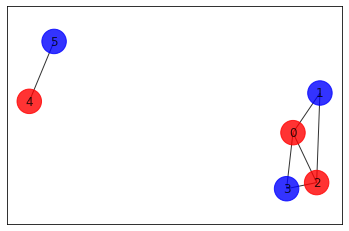

In [33]:
# brute force
import time
start = time.time()
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute <= cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute) + ' time taken: {:.5f}s'.format(time.time()-start))

#### Explorations

In [10]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.quantum_info import Pauli

paulis = [[0.5, Pauli([True, True], [False, False])]]
print(WeightedPauliOperator(paulis).to_dict())

paulis = [[0.5, Pauli([True, False], [False, False])]]
print(WeightedPauliOperator(paulis).to_dict())

paulis = [[0.5, Pauli([True, False], [False, True])]]
print(WeightedPauliOperator(paulis).to_dict())

{'paulis': [{'label': 'ZZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]}
{'paulis': [{'label': 'IZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]}
{'paulis': [{'label': 'XZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]}


In [11]:
print(w)
qubitOp, offset = max_cut.get_operator(w)
print(qubitOp.to_dict(), offset)
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
{'paulis': [{'label': 'IIZZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]} -0.5
energy: -0.5


In [12]:
w = np.zeros([2,2])
w[0,1] = 1
w[1,0] = 1
print(w)
qubitOp, offset = max_cut.get_operator(w)
print(qubitOp.to_dict(), offset)
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])

[[0. 1.]
 [1. 0.]]
{'paulis': [{'label': 'ZZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]} -0.5
energy: -0.5


In [13]:
w = np.zeros([3,3])
w[0,1] = 1
w[1,0] = 1
print(w)
qubitOp, offset = max_cut.get_operator(w)
print(qubitOp.to_dict(), offset)
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
{'paulis': [{'label': 'IZZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]} -0.5
energy: -0.5


In [14]:
w = np.zeros([3,3])
w[0,2] = 1
w[2,0] = 1
print(w)
qubitOp, offset = max_cut.get_operator(w)
print(qubitOp.to_dict(), offset)
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])

[[0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]]
{'paulis': [{'label': 'ZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]} -0.5
energy: -0.5


In [15]:
paulis = [[0.5, Pauli([True, False], [False, True])]]
qubitOp = WeightedPauliOperator(paulis)
print(qubitOp.to_dict(), offset)
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])

{'paulis': [{'label': 'XZ', 'coeff': {'real': 0.5, 'imag': 0.0}}]} -0.5
energy: -0.5


In [16]:
paulis = [[0.5, Pauli([False, False, True], [True, True, True])]]
qubitOp = WeightedPauliOperator(paulis)
print(qubitOp.to_dict(), offset)
result = ExactEigensolver(qubitOp).run()
# print('objective function:', max_cut.max_cut_obj(result, offset))
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])

{'paulis': [{'label': 'YXX', 'coeff': {'real': 0.5, 'imag': 0.0}}]} -0.5
energy: -0.5000000000000001
